# Classification of Coins

Built a Convolutional Neural Network to classify the coins into 5 classes where the labels are given in the file names. Able to achieve the best **Test Accuracy of 97.5%** with just 20 epochs training the model. Can still improve the accuracy by tuning the HyperParameters and running more epochs, However we should make sure model is not overfitted which can be overcomed by adding Regularization, Dropouts etc.

In [1]:
#importing the libraries
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf


In [2]:
from pathlib import Path
data_dir=Path('classification_dataset/all/')

In [3]:
#Total number of images
image_count=len(list(data_dir.glob('*.jpg')))
image_count

3059

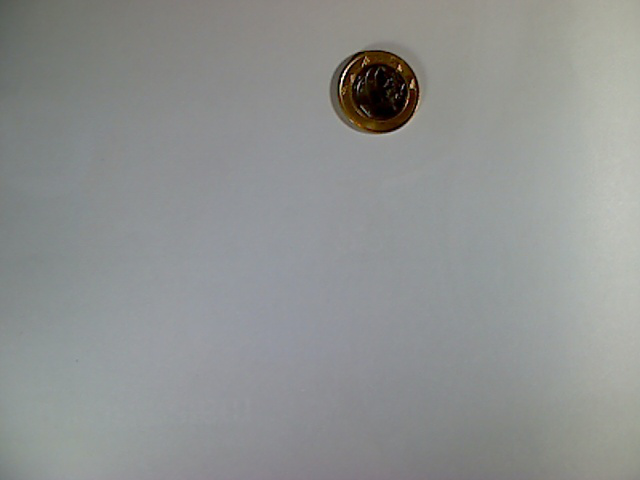

In [4]:
#opening the image
index=100
image_files=list(data_dir.glob('*.jpg'))
PIL.Image.open(str(image_files[index]))

In [5]:
image_files[:10]

[WindowsPath('classification_dataset/all/100_1477154436.jpg'),
 WindowsPath('classification_dataset/all/100_1477154442.jpg'),
 WindowsPath('classification_dataset/all/100_1477154448.jpg'),
 WindowsPath('classification_dataset/all/100_1477154454.jpg'),
 WindowsPath('classification_dataset/all/100_1477154460.jpg'),
 WindowsPath('classification_dataset/all/100_1477154466.jpg'),
 WindowsPath('classification_dataset/all/100_1477154472.jpg'),
 WindowsPath('classification_dataset/all/100_1477154478.jpg'),
 WindowsPath('classification_dataset/all/100_1477154484.jpg'),
 WindowsPath('classification_dataset/all/100_1477154490.jpg')]

In [6]:
#initializing the image size
image_size=180
def read_file(fname):
   
    image = PIL.Image.open(fname)
    
    image.thumbnail((image_size, image_size))
    
    image_array = np.asarray(image)
    
    #Get the target
    target = int(fname.stem.split('_')[0])

    return image_array, target

In [7]:
images = []
targets = []

for image_file in image_files:
    image, target = read_file(image_file)
    
    images.append(image)
    targets.append(target)

In [8]:
#converting to numpy array
x=np.array(images)
y=np.array(targets)

In [9]:
x.shape

(3059, 135, 180, 3)

In [11]:
y.dtype

dtype('int32')

In [12]:
y[:10]

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])

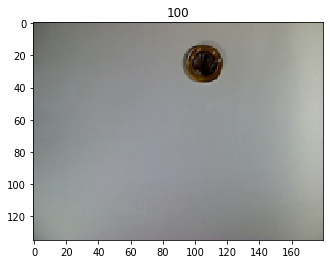

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

#plotting the image with the class
plt.imshow(x[index])
plt.title(str(y[index]));

In [15]:
# Label encoding the target variable
coins_ids = {
    5: 0,
    10: 1,
    25: 2,
    50: 3,
    100: 4
}

ids = [5, 10, 25, 50, 100]

y = np.array([coins_ids[coin] for coin in y])

In [16]:
# Imported train_test_split to split the data
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=10)

In [17]:
x_train.shape, y_train.shape

((2447, 135, 180, 3), (2447,))

In [18]:
# Importing Keras layers and optimizers
from keras.layers import Conv2D,MaxPool2D,Activation,Flatten,Dense,BatchNormalization,GlobalAvgPool2D,Dropout
from keras.optimizers import Adam


In [19]:
# Built a Convolutional neural network using Functional API
def Convolutional_model(input_shape):
    
    input_img=tf.keras.Input(shape=input_shape)
    
    # CONV2D => BatchNormalization => RELU => MaxPool2D
    X=Conv2D(filters=16,kernel_size=3,padding='same')(input_img)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    X=MaxPool2D(2)(X)
    
    # CONV2D => BatchNormalization => RELU => MaxPool2D
    X=Conv2D(filters=32,kernel_size=3,padding='same')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    X=MaxPool2D(2)(X)
    
    # CONV2D => BatchNormalization => RELU => MaxPool2D
    X=Conv2D(filters=64,kernel_size=3,padding='same')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    X=MaxPool2D(2)(X)
    
    # CONV2D => BatchNormalization => RELU => MaxPool2D
    X=Conv2D(filters=128,kernel_size=3,padding='same')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    X=MaxPool2D(2)(X)
    
    X=Conv2D(filters=256, kernel_size=3, padding='same')(X)
    X=Activation('relu')(X)
    
    X=GlobalAvgPool2D()(X)
    
    X=Flatten()(X)
    
    X=Dense(512,activation='relu')(X)
    # Added Dropout to minimize overfitting
    X=Dropout(0.2)(X)
    
    X=Dense(5,activation='softmax')(X)
    model = tf.keras.Model(inputs=input_img, outputs=X)
    return model

In [20]:
conv_model=Convolutional_model((135,180,3))

In [21]:
#Summary of the Model
conv_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 135, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 135, 180, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 135, 180, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 135, 180, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 67, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 90, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 67, 90, 32)       

In [22]:
#Adam Optimizer
optimizer=Adam(lr=1e-3)

#Sparse Categorical crossentropy loss function is used as the target variable is label encoded
conv_model.compile(optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
from keras.callbacks import ModelCheckpoint

#Checkpointer to get the parameters of the model having best validation accuracy
checkpointer=ModelCheckpoint('BestModel.weights.hdf5',save_best_only=True)

train_dataset=tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(64)
test_dataset=tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(64)

### can improve val accuracy if it is trained on more epochs
history=conv_model.fit(train_dataset,epochs=20,validation_data=test_dataset,callbacks=[checkpointer],verbose=0)

In [24]:
import pandas as pd
df_history=pd.DataFrame(history.history)

In [25]:
# Getting the weights of best validation accuracy model
conv_model.load_weights('BestModel.weights.hdf5')

In [26]:
#evaluating the model
score=conv_model.evaluate(x_test,y_test)
print('\n','Test Accuracy:', score[1])

20/20 [==============================] - 4s 175ms/step - loss: 0.0854 - accuracy: 0.9755

 Test Accuracy: 0.9754902124404907


In [30]:
#predicting the classes
y_pred=conv_model.predict(x_test)

In [32]:
y_pred.shape

(612, 5)

In [33]:
y_predic=y_pred.argmax(1)

In [34]:
y_predic[:10]

array([0, 2, 1, 3, 1, 3, 4, 2, 1, 1], dtype=int64)

In [35]:
errors=np.where(y_predic!=y_test)

In [37]:
errors

(array([ 38,  92,  93,  98, 151, 160, 190, 193, 283, 327, 337, 499, 510,
        549, 606], dtype=int64),)

In [40]:
i=25
print('Actual Class: {}, Predicted Class: {}'.format(ids[y_test[i]],ids[y_predic[i]]))

Actual Class: 100, Predicted Class: 100
